In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import networkx as nx
from sklearn.linear_model import LogisticRegression
from joblib import dump, load
import random
from tqdm import tqdm
import math
import json
import jax.numpy as jnp
from jax import grad, vmap, jit
from joblib import dump, load
import os
import seaborn as sns
import plotly.graph_objects as go
import scipy.stats as stats
import glob
from collections import defaultdict



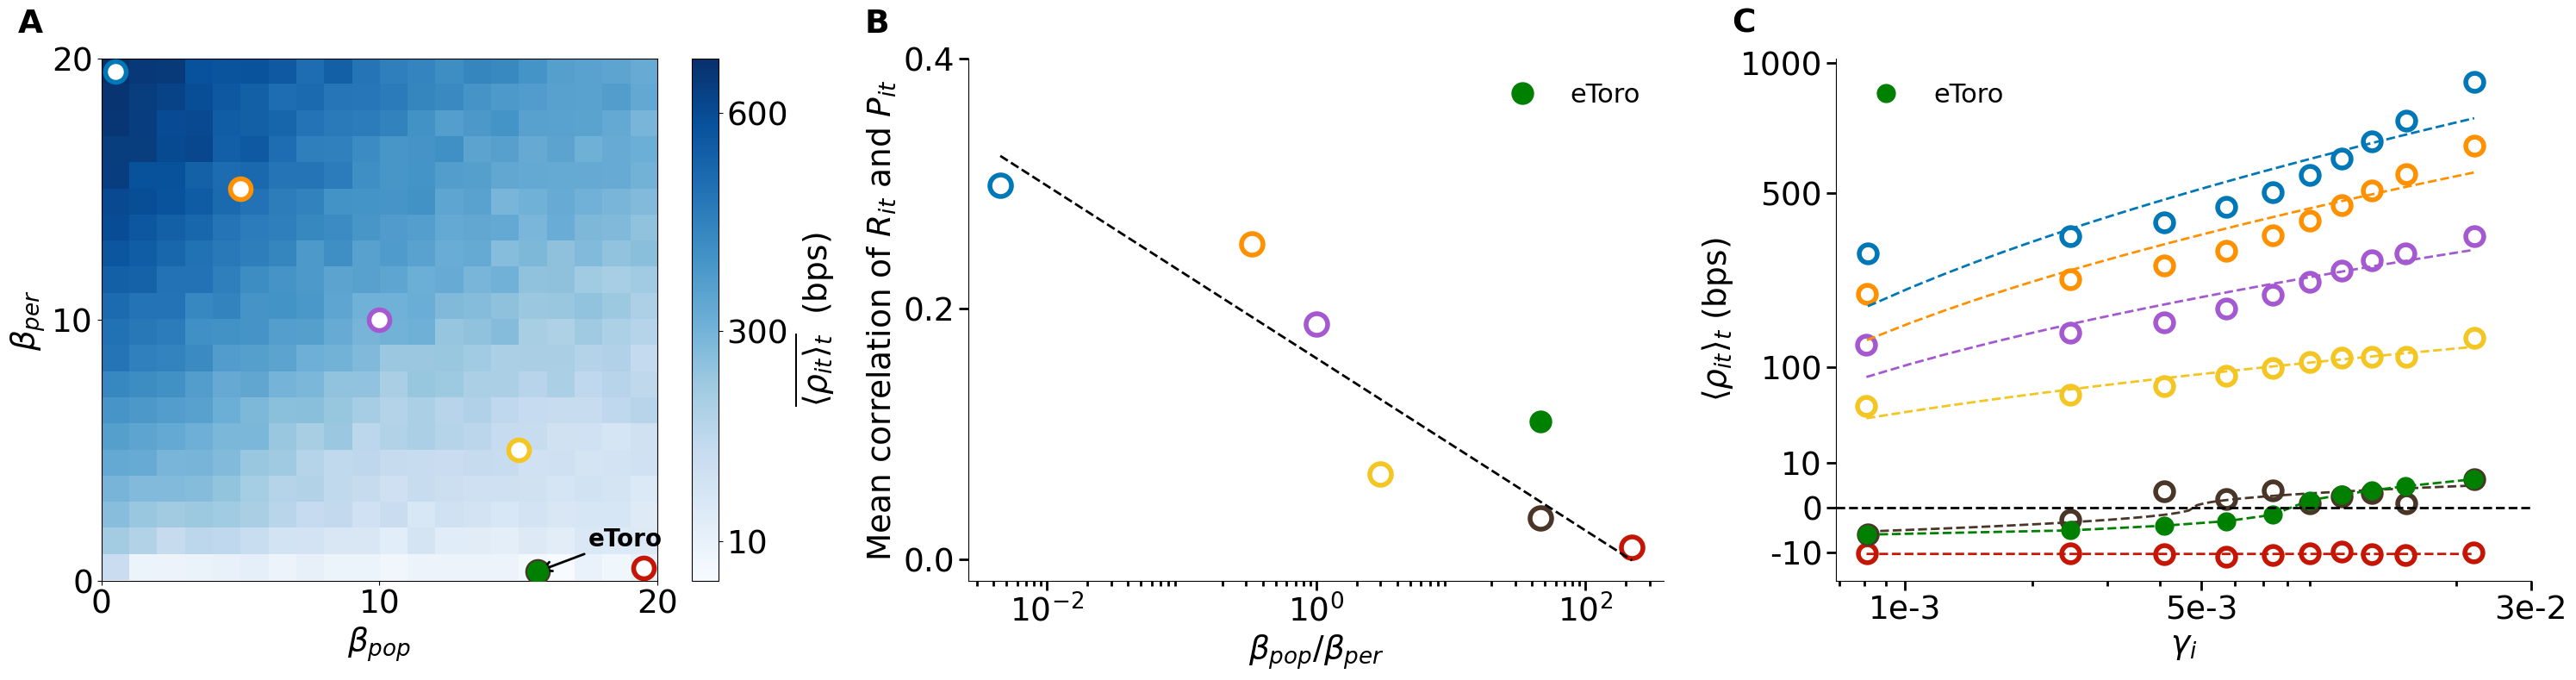

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.scale import FuncScale
import matplotlib.gridspec as gridspec
import seaborn as sns


def signed_sqrt(x):
    return np.sign(x) * np.sqrt(np.abs(x))

def inverse_signed_sqrt(y):
    return np.sign(y) * (np.abs(y) ** 2)


# Panel A
df_panelA = pd.read_csv("../data/fig3_a.csv", index_col=0)
beta_popularity_values = df_panelA.columns.astype(float)
beta_performance_values = df_panelA.index.astype(float)
av_perf = df_panelA.values

# Panel B
df_panelB = pd.read_csv("../data/fig3_b.csv")
df_etoro_B = pd.read_csv("../data/fig3_b_etoro.csv")

# Panel C
df_panelC = pd.read_csv("../data/fig3_c.csv")
df_etoro_C = pd.read_csv("../data/fig3_c_etoro.csv")

unique_pairs = list(zip(df_panelB["beta_pop"], df_panelB["beta_perf"]))
color_list = ['#C51605', '#F3C623', '#A459D1', '#493628', '#FF9100', '#0077B6']
pair_colors = dict(zip(unique_pairs, color_list))


fig = plt.figure(figsize=(30, 8))  
gs = gridspec.GridSpec(1, 3)  

ax1 = fig.add_subplot(gs[0])
c1 = ax1.imshow(av_perf, aspect='auto', cmap="Blues", 
                extent=[beta_popularity_values.min(), beta_popularity_values.max(), 
                        beta_performance_values.min(), beta_performance_values.max()],
                origin='lower')
ax1.set_xlabel(r'$\beta_{pop}$', size=27)
ax1.set_ylabel(r'$\beta_{per}$', size=27)     
cbar1 = fig.colorbar(c1, ax=ax1)
cbar1.set_label(r'$\overline{\langle\rho_{it}\rangle_t}$  (bps)', size=27)
cbar1.set_ticks([10, 300, 600]) 
ax1.text(-0.15, 1.05, 'A', transform=ax1.transAxes, size=27, weight='bold')

for (beta_pop, beta_perf), color in pair_colors.items():
    if (beta_pop, beta_perf) == (0.09, 20):
        ax1.scatter(0.5, 19.5, color=color, s=300, facecolors='white', edgecolor=color, linewidths=4, zorder=3)
    elif (beta_pop, beta_perf) == (20.0, 0.09):
        ax1.scatter(19.5, 0.5, color=color, s=300, facecolors='white', edgecolor=color, linewidths=4, zorder=3)
    else:
        ax1.scatter(beta_pop, beta_perf, color=color, s=300, facecolors='white', edgecolor=color, linewidths=4, zorder=3)

ax1.scatter(15.68, 0.34, facecolors='green', edgecolors='green', s=300, zorder=5)
ax1.annotate('eToro', xy=(15.68, 0.34), xycoords='data',
             xytext=(17.5, 1.34), textcoords='data',
             arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=2),
             fontsize=20, color='black', weight='bold')
ax1.tick_params(axis='both', which='major', labelsize=27)
cbar1.ax.tick_params(labelsize=27)
ax1.set_xticks(np.arange(0, 21, 10))  
ax1.set_yticks(np.arange(0, 21, 10))

ax2 = fig.add_subplot(gs[1])
for (_, row), color in zip(df_panelB.iterrows(), color_list):
    ax2.plot(row["beta_ratio"], row["mean_corr"], 'o', color=color, mfc='none', mec=color, mew=4, markersize=18)

log_beta_ratio = np.log(df_panelB["beta_ratio"])
slope, intercept = np.polyfit(log_beta_ratio, df_panelB["mean_corr"], 1)
x_fit = np.linspace(min(log_beta_ratio), max(log_beta_ratio), 100)
y_fit = slope * x_fit + intercept
ax2.plot(np.exp(x_fit), y_fit, linestyle='--', color='black', linewidth=2)

# eToro point
ax2.plot(df_etoro_B["beta_ratio"], df_etoro_B["mean_corr"], 'o', mfc='green', color='green', mec='green', label='eToro', markersize=18)
ax2.set_xlabel(r'$\beta_{pop} / \beta_{per}$', fontsize=27)
ax2.set_ylabel(r'Mean correlation of $R_{it}$ and $P_{it}$', fontsize=27)
ax2.set_xscale('log')
ax2.set_xticks([0.01, 1, 100])
ax2.set_yticks([0, 0.2, 0.4])
ax2.tick_params(axis='both', which='major', labelsize=27, length=8, width=2)
ax2.tick_params(axis='both', which='minor', labelsize=20, length=4, width=2)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.legend(fontsize=22, loc='upper right', frameon=False)
ax2.text(-0.15, 1.05, 'B', transform=ax2.transAxes, size=27, weight='bold')

ax3 = fig.add_subplot(gs[2])
ax3.set_yscale(FuncScale(ax3, functions=(signed_sqrt, inverse_signed_sqrt)))
ax3.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{inverse_signed_sqrt(y):.0f}"))

for (beta_pop, beta_perf), color in pair_colors.items():
    df_sub = df_panelC[(df_panelC["beta_pop"] == beta_pop) & (df_panelC["beta_perf"] == beta_perf)]
    if df_sub.empty:
        continue
    et_gam = df_sub["Gamma"]
    mean_perf = df_sub["mean"]
    ax3.plot(et_gam/5000, mean_perf, 'o', color=color, mfc='none', mec=color, mew=4, markersize=15)

    if len(et_gam) > 1:
        log_gamma = np.log(et_gam)
        slope, intercept = np.polyfit(log_gamma, mean_perf, 1)
        x_fit = np.linspace(min(et_gam), max(et_gam), 100)
        y_fit = slope * np.log(x_fit) + intercept
        ax3.plot(x_fit/5000, y_fit, linestyle='--', color=color, alpha=1.0, linewidth=2)


ax3.plot(df_etoro_C["gamma"]/5000, df_etoro_C["predicted_perf"], 'o', color='green', mfc='green', mec='green', label='eToro', markersize=15)
ax3.plot(df_etoro_C["gamma"]/5000, df_etoro_C["predicted_perf"], linestyle='--', color='green', linewidth=2)

ax3.axhline(0, color='black', linestyle='--', linewidth=2)
ax3.set_xlabel(r'$\gamma_i$', fontsize=27)
ax3.set_ylabel(r'$\langle\rho_{it}\rangle_t$ (bps)', fontsize=27)
ax3.set_xscale('log')
ax3.set_xticks([0.001, 0.005, 0.03])
ax3.set_xticklabels(['1e-3', '5e-3', '3e-2'])
ax3.set_yticks([-10, 0.0, 10, 100, 500, 1000])
ax3.set_yticklabels(['-10', '0', '10', '100', '500', '1000'])
ax3.tick_params(axis='both', which='major', labelsize=27, length=8, width=2)
ax3.tick_params(axis='both', which='minor', labelsize=20, length=4, width=2)
ax3.legend(fontsize=22, loc='upper left', frameon=False)
ax3.grid(False)
sns.despine(ax=ax3)
ax3.text(-0.15, 1.05, 'C', transform=ax3.transAxes, size=27, weight='bold')

plt.tight_layout()
plt.savefig('../images/figure_3.pdf', format='pdf')
plt.show()